# Sudoku solver

In classic Sudoku, the objective is to fill a 9 × 9 grid with digits so that each column, each row, and each of the nine 3 × 3 subgrids that compose the grid (also called "boxes", "blocks", or "regions") contains all of the digits from 1 to 9.

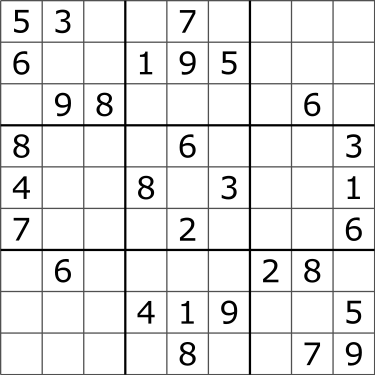

## Prepare environment

In [1]:
import sys
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

project_root = os.getcwd()
src_dir = os.path.join(project_root, "src")
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

from sudoku_solver.data.dataset import prepare_dataset
from sudoku_solver.data.preprocess import preprocess_input, preprocess_target
from sudoku_solver.model.model import prepare_model
from sudoku_solver.model.training import prepare_callbacks
from sudoku_solver.model.evaluation import plot_histories

from sklearn.metrics import accuracy_score

import numpy as np
import tensorflow as tf
import keras

# Uncomment for debugging
# tf.config.run_functions_eagerly(True)

# Enable mixed precision training to speed up computation
# WARNING: turn off if you run this on CPU - it will significantly slow down training
# https://keras.io/api/mixed_precision/
#
# Enable when training takes too long - it lowered training time by 14% and increased error rate by 16%
keras.mixed_precision.set_global_policy("mixed_float16")

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(42)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
# tf.config.experimental.enable_op_determinism()

MODEL_FILE_NAME = "sudoku_solver.keras"

E0000 00:00:1746458720.069188  279084 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746458720.075198  279084 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Hyperparameters

In [2]:
# We need to limit data to be able to run faster experiments
DATA_SIZE_LIMIT = 1_500_000

BATCH_SIZE = 256 # Best accurracy & time for current learning rate
LEARNING_RATE = 1e-3
EPOCHS = 10

# Use residual connections in convolutional model architecture
USE_RESIDUAL = True

# Idea is to pretrain model on solution-only data (self-supervised learning) like autoencoder
#
# Note: There is no performance improvement on small data sample (10%) and few epochs training (1)
# Turn on when training with more data and epochs to see if it helps
USE_PRE_TRAINING = False

# Disk cache is slower but a must if we can't load everything into a memory
USE_DISK_CACHE = False

# Idea is to let model learn first on easy problems and then gradually increase problem difficulty
USE_CURRICULUM_LEARNING = True

# Idea is to create a layer that would penalise predictions that break Sudoku rules
CONSTRAINT_WEIGHT = 0.1

# Penalise predictions that don't adhere to fixed digits
FIXED_CELL_WEIGHT = 0.1

# Replace predictions for fixed numbers with actuall fixed numbers
#
# Idea is to force model to ignore fixed numbers
#
# Note: so far it seems that model is unable to learn with this turned on
USE_FIXED_NUMBER_LAYER = False

## Prepare dataset

In [3]:
train_datasets, val_dataset, test_dataset = prepare_dataset(BATCH_SIZE, size_limit=DATA_SIZE_LIMIT, use_disk_cache=USE_DISK_CACHE)

Trying to prepare dataset from disk


I0000 00:00:1746458728.103808  279084 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2874 MB memory:  -> device: 0, name: Quadro P600, pci bus id: 0000:01:00.0, compute capability: 6.1


Dataset ready.


Measuring pipeline performance...:  56%|█████▌    | 556/1000 [00:08<00:06, 64.08it/s]

Average batch fetch time is: 0.018441519566944668


In [4]:
print("Validate dataset pipeline:\n")
for X_batch, y_batch in train_datasets[0].take(1):
    for X, y in zip(X_batch, y_batch):
        # TODO: can't we reuse this conversion back to readable Sudoku puzzle? (e.g. invert operation)
        print(((X + 0.5) * 9).numpy().reshape((9, 9)).astype(int))
        print((y + 1).numpy().reshape((9, 9)))
        break

Validate dataset pipeline:

[[1 4 9 7 2 5 3 8 6]
 [0 0 5 3 9 8 1 4 7]
 [7 3 8 4 1 6 9 5 2]
 [8 7 3 9 6 2 4 0 5]
 [0 6 4 1 5 3 7 9 8]
 [5 9 0 0 4 7 6 2 3]
 [3 1 7 0 8 9 2 6 4]
 [4 0 2 6 3 1 5 7 9]
 [9 0 0 2 0 4 8 3 1]]
[[ 1  4  9  7  2  5  3  8  6]
 [16 12  5  3  9  8  1  4  7]
 [ 7  3  8  4  1  6  9  5  2]
 [ 8  7  3  9  6  2  4 11  5]
 [12  6  4  1  5  3  7  9  8]
 [ 5  9 11 18  4  7  6  2  3]
 [ 3  1  7 15  8  9  2  6  4]
 [ 4 18  2  6  3  1  5  7  9]
 [ 9 15 16  2 17  4  8  3  1]]


In [5]:
train_batch_size = sum(1 for _ in train_datasets[0])
train_batch_size

556

## Train model

### Prepare model

In [6]:
model = prepare_model(
    use_residual=USE_RESIDUAL,
    use_fixed_number_layer=USE_FIXED_NUMBER_LAYER,
    learning_rate=LEARNING_RATE,
    fixed_cell_penalty_weight=FIXED_CELL_WEIGHT,
    constraint_weight=CONSTRAINT_WEIGHT,
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 9, 9, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 9, 9, 1)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 9, 9, 64)  │        640 │ cast[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 9, 9, 64)  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 9, 9, 64)  │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 9, 9, 64)  │          0 │ add_1[0][0]     

 Total params: 7,944,713 (30.31 MB)

 Trainable params: 7,943,049 (30.30 MB)

 Non-trainable params: 1,664 (6.50 KB)

### Train

In [7]:
histories = []
initial_epoch = 0
for train_dataset in train_datasets:
    training_callbacks = prepare_callbacks()

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=initial_epoch + EPOCHS,
        callbacks=training_callbacks,
        initial_epoch=initial_epoch
    )
    histories.append(history)

    initial_epoch += EPOCHS

Epoch 1/10


I0000 00:00:1746458756.629937  279181 service.cc:148] XLA service 0x7fcb58003dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746458756.629979  279181 service.cc:156]   StreamExecutor device (0): Quadro P600, Compute Capability 6.1
I0000 00:00:1746458758.070961  279181 cuda_dnn.cc:529] Loaded cuDNN version 90700
I0000 00:00:1746458776.945031  279181 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


556/556 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.0969 - box_penalty: 0.0973 - col_penalty: 0.0959 - loss: 1.2570 - row_penalty: 0.0913
Penalties:
crossentropy_tracker:  tf.Tensor(0.4707842, shape=(), dtype=float32)
total_penalty_tracker:  tf.Tensor(0.5524077, shape=(), dtype=float32)
row_penalty_tracker:  tf.Tensor(0.0814107, shape=(), dtype=float32)
col_penalty_tracker:  tf.Tensor(0.084440485, shape=(), dtype=float32)
box_penalty_tracker:  tf.Tensor(0.078172475, shape=(), dtype=float32)
cell_penalty_tracker:  tf.Tensor(52.800526, shape=(), dtype=float32)
0 <Variable path=constraint_weight, shape=(), dtype=float32, value=0.10000000149011612>
556/556 ━━━━━━━━━━━━━━━━━━━━ 114s 153ms/step - accuracy: 0.0970 - box_penalty: 0.0972 - col_penalty: 0.0958 - loss: 1.2569 - row_penalty: 0.0912 - val_accuracy: 0.1705 - val_box_penalty: 0.2138 - val_col_penalty: 0.2309 - val_loss: 0.7770 - val_row_penalty: 0.2279 - learning_rate: 0.0010
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step

### Save model

In [8]:
model.save(MODEL_FILE_NAME)

## Evaluate model

### Plot training history as learning curves

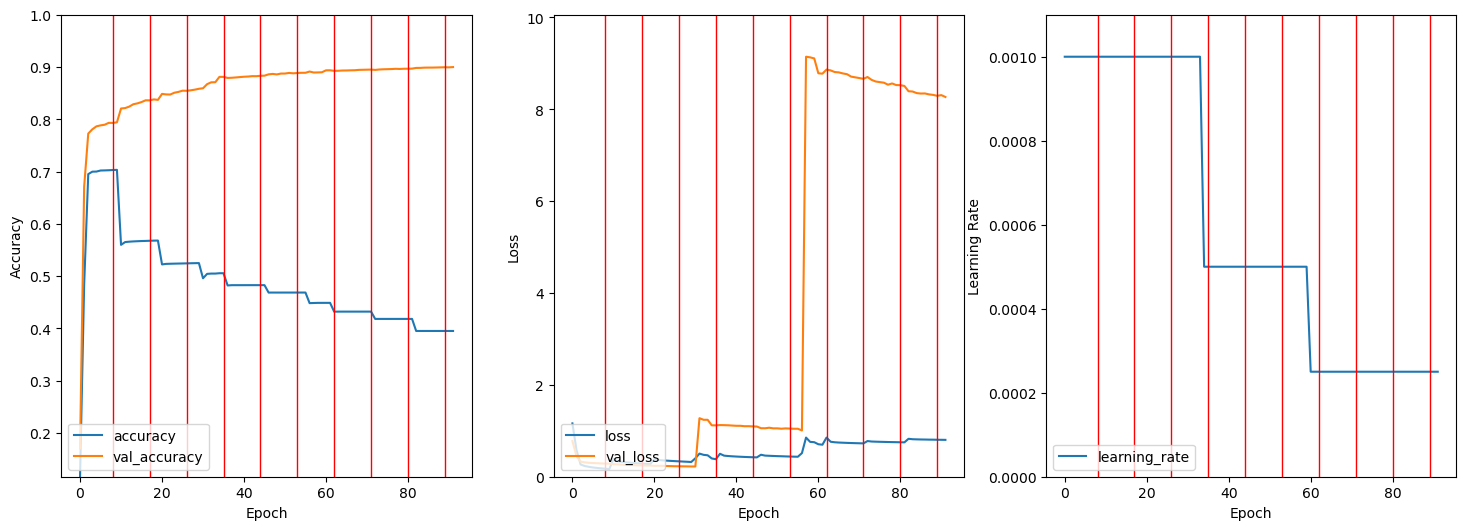

In [9]:
plot_histories(histories)

### Load model from disk to get reproducible results

In [10]:
model = keras.saving.load_model(MODEL_FILE_NAME)

### Evaluate selected puzzles

In [11]:
def prepare_input_batch(puzzle):
    reshaped = preprocess_input(puzzle)
    reshaped_batch = tf.expand_dims(reshaped, axis=0)
    return reshaped_batch

In [12]:
def prepare_target_batch(solution):
    reshaped = preprocess_target(solution)
    reshaped_batch = tf.expand_dims(reshaped, axis=0)
    return reshaped_batch

In [13]:
def solve_sudoku(puzzle):
    reshaped_batch = prepare_input_batch(puzzle)
    predictions = model.predict(reshaped_batch)
    result = np.argmax(predictions, axis=-1) + 1 # predictions are 0-based but game starts with 1
    return result

In [14]:
result = solve_sudoku(
    ""
    "800250704"
    "420000000"
    "000008065"
    "000045300"
    "004603100"
    "007910000"
    "540700000"
    "000000089"
    "209086001"
).reshape((9,9))

print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[8 9 6 2 5 9 7 3 4]
 [4 2 5 3 6 7 8 1 8]
 [7 9 1 4 3 8 2 6 5]
 [1 1 2 8 4 5 3 9 7]
 [9 5 4 6 7 3 1 2 2]
 [3 8 7 9 1 2 5 4 6]
 [5 4 8 7 9 1 6 2 3]
 [7 6 3 5 2 4 4 8 9]
 [2 3 9 3 8 6 4 7 1]]


In [15]:
puzzle = (""
    "800250704"
    "420000000"
    "000008065"
    "000045300"
    "004603100"
    "007910000"
    "540700000"
    "000000089"
    "209086001"
)
solution = (""
    "863259714"
    "425167938"
    "791438265"
    "612845397"
    "984673152"
    "357912846"
    "548791623"
    "176324589"
    "239586471"
)

accuracy, loss, *rest = model.evaluate(prepare_input_batch(puzzle), prepare_target_batch(solution))

W0000 00:00:1746466520.177855  279182 assert_op.cc:38] Ignoring Assert operator compile_loss/sudoku_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7901 - box_penalty: 0.0044 - col_penalty: 0.0053 - loss: 17.1840 - row_penalty: 0.0040


In [16]:
result = solve_sudoku(""
"400510607"
"050007020"
"300020041"
"035960000"
"600400015"
"014002008"
"060075093"
"001000700"
"703098052"
).reshape((9,9))

print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[4 2 2 5 1 9 6 3 7]
 [1 5 6 3 4 7 8 2 9]
 [3 7 7 8 2 6 5 4 1]
 [8 3 5 9 6 1 2 7 4]
 [6 7 7 4 8 3 2 1 5]
 [9 1 4 7 5 2 9 6 8]
 [8 6 8 1 7 5 4 9 3]
 [5 9 1 2 3 4 7 8 6]
 [7 4 3 6 9 8 1 5 2]]


In [17]:
puzzle = (""
"400510607"
"050007020"
"300020041"
"035960000"
"600400015"
"014002008"
"060075093"
"001000700"
"703098052"
)

solution = (
    ""
    "482519637"
    "156347829"
    "379826541"
    "835961274"
    "627483915"
    "914752368"
    "268175493"
    "591234786"
    "743698152"
)

loss, accuracy, *rest = model.evaluate(prepare_input_batch(puzzle), prepare_target_batch(solution))
accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9259 - box_penalty: 0.0033 - col_penalty: 0.0039 - loss: 6.1609 - row_penalty: 0.0042


0.9259259104728699

### Evaluate on different difficulties

In [18]:
for index, train_dataset in enumerate(train_datasets):
    batch_count = 10
    total_loss = 0.0
    total_accuracy = 0.0
    total_non_zero_count = 0

    for X_batch, y_batch in train_dataset.take(batch_count):
        y_batch_without_flag = tf.cast(tf.where(y_batch >= 10, y_batch - 10, y_batch), tf.float32)

        loss, accuracy, *rest = model.evaluate(X_batch, y_batch_without_flag, verbose=0)
        total_loss += loss
        total_accuracy += accuracy
        total_non_zero_count += tf.reduce_mean(tf.math.count_nonzero((X_batch + 0.5) * 9, axis=(1, 2)))

    avg_loss = total_loss / batch_count
    avg_accuracy = total_accuracy / batch_count
    print(f"Difficulty {index + 1}: loss={avg_loss}, accuracy={avg_accuracy}")

    avg_non_zero = int(total_non_zero_count / batch_count)
    print(f"Average non-zero numbers in puzzle in one batch: {avg_non_zero}\n")


Difficulty 1: loss=0.08184659034013748, accuracy=0.9999614238739014
Average non-zero numbers in puzzle in one batch: 68

Difficulty 2: loss=2.049692702293396, accuracy=0.9763069093227387
Average non-zero numbers in puzzle in one batch: 47

Difficulty 3: loss=3.3795738220214844, accuracy=0.9600742876529693
Average non-zero numbers in puzzle in one batch: 44

Difficulty 4: loss=5.269584226608276, accuracy=0.9368923783302308
Average non-zero numbers in puzzle in one batch: 41

Difficulty 5: loss=6.066893529891968, accuracy=0.9270833432674408
Average non-zero numbers in puzzle in one batch: 40

Difficulty 6: loss=7.931747484207153, accuracy=0.9041088163852692
Average non-zero numbers in puzzle in one batch: 38

Difficulty 7: loss=9.149110126495362, accuracy=0.8891107320785523
Average non-zero numbers in puzzle in one batch: 37

Difficulty 8: loss=11.142582511901855, accuracy=0.8645013451576233
Average non-zero numbers in puzzle in one batch: 35

Difficulty 9: loss=12.458855438232423, accur

### Evaluate test set performance

In [19]:
loss, accuracy, *rest = model.evaluate(test_dataset)

146/146 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.9001 - box_penalty: 0.0032 - col_penalty: 0.0038 - loss: 8.2473 - row_penalty: 0.0038


In [20]:
print(f"On test set, model achieved accuracy: {accuracy} and loss: {loss}")

On test set, model achieved accuracy: 0.8999998569488525 and loss: 8.255692481994629


### Evaluate after replacing fixed positions with fixed numbers

In [21]:
x_test = []
y_true = []

for X, y in test_dataset:
    x_test.append(X.numpy())
    y_true.append(y.numpy())

x_test = np.concatenate(x_test, axis=0)
y_true = np.concatenate(y_true, axis=0)

y_pred = model.predict(x_test)
# predictions are 0-based but puzzle solution numbers start with 1
y_pred_classes = np.argmax(y_pred, axis=-1) + 1

# revert preprocessing so numbers are as in puzzles
x_test_fixed = ((x_test + 0.5) * 9).reshape((-1, 9, 9))
y_true_fixed = y_true + 1

# replace fixed positions in predictions with actual fixed numbers
y_pred_fixed = np.where(x_test_fixed == 0, y_pred_classes, x_test_fixed)

accuracy_metric = keras.metrics.Accuracy()
accuracy_metric.update_state(y_true_fixed, y_pred_fixed)
print(f"Test Set Accuracy: {accuracy_metric.result().numpy():.8f}")

1168/1168 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step
Test Set Accuracy: 0.89999986


The End

In [22]:
# TODO: reintroduce Fixed Cell Penalty
# TODO: prepare tests (hyperparameters, experiments, save figures, times, etc.)